In [218]:
#First import the necessary packages
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from scipy import stats
import os
import numpy as np
import statsmodels as sm



In [156]:
#Establish the database connection
conn = sqlite3.Connection('database.sqlite')
c = conn.cursor()



In [157]:
#Taking a look at the tables in the database
tables = c.execute('''select name from sqlite_master where type = "table"''').fetchall()
tables


[('sqlite_sequence',),
 ('Player_Attributes',),
 ('Player',),
 ('Match',),
 ('League',),
 ('Country',),
 ('Team',),
 ('Team_Attributes',)]

In [158]:
#making a string to add all the bookies to the query
bookies = "d.B365H, d.B365D, d.B365A, d.BWH, d.BWD, d.BWA, d.IWH, d.IWD, d.IWA, d.LBH, d.LBD, d.LBA, d.PSH, d.PSD, d.PSA, d.WHH, d.WHD, d.WHA, d.SJH, d.SJD, d.SJA, d.VCH, d.VCD, d.VCA, d.GBH, d.GBD, d.GBA, d.BSH, d.BSD, d.BSA"
bookies = bookies.replace('d','m')
bookies


'm.B365H, m.B365D, m.B365A, m.BWH, m.BWD, m.BWA, m.IWH, m.IWD, m.IWA, m.LBH, m.LBD, m.LBA, m.PSH, m.PSD, m.PSA, m.WHH, m.WHD, m.WHA, m.SJH, m.SJD, m.SJA, m.VCH, m.VCD, m.VCA, m.GBH, m.GBD, m.GBA, m.BSH, m.BSD, m.BSA'

In [159]:
#main query gets win loss data and bookie odds
q=("""
        SELECT m.home_team_goal, m.away_team_goal, m.home_team_api_id, {} FROM 
        Match m
        
        """.format(bookies))

df = pd.read_sql_query(q, conn)
    

In [160]:
df.columns

Index(['home_team_goal', 'away_team_goal', 'home_team_api_id', 'B365H',
       'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH',
       'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD',
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object')

In [161]:
#Sets up columns to see who won or lost or draw
df['HomeWin']=df.home_team_goal>df.away_team_goal
df['AwayWin']=df.away_team_goal>df.home_team_goal
df['Draw']=df.home_team_goal==df.away_team_goal



In [162]:
df.head()

,home_team_goal,away_team_goal,home_team_api_id,B365H,B365D,B365A,BWH,BWD,BWA,IWH,...,VCA,GBH,GBD,GBA,BSH,BSD,BSA,HomeWin,AwayWin,Draw
0,1,1,9987,1.73,3.40,5.00,1.75,3.35,4.20,1.85,...,4.50,1.78,3.25,4.00,1.73,3.40,4.20,False,False,True
1,0,0,10000,1.95,3.20,3.60,1.80,3.30,3.95,1.90,...,3.25,1.85,3.25,3.75,1.91,3.25,3.60,False,False,True
2,0,3,9984,2.38,3.30,2.75,2.40,3.30,2.55,2.60,...,2.65,2.50,3.20,2.50,2.30,3.20,2.75,False,True,False
3,5,0,9991,1.44,3.75,7.50,1.40,4.00,6.80,1.40,...,6.50,1.50,3.75,5.50,1.44,3.75,6.50,True,False,False
4,1,3,7947,5.00,3.50,1.65,5.00,3.50,1.60,4.00,...,1.65,4.50,3.50,1.65,4.75,3.30,1.67,False,True,False


In [163]:
#Convert odds to implied probability
for column in df.loc[:,'B365H':'BSA']:
    df[column]= df[column]/(1+df[column])
    
    

In [164]:
df.head()

,home_team_goal,away_team_goal,home_team_api_id,B365H,B365D,B365A,BWH,BWD,BWA,IWH,...,VCA,GBH,GBD,GBA,BSH,BSD,BSA,HomeWin,AwayWin,Draw
0,1,1,9987,0.633700,0.772727,0.833333,0.636364,0.770115,0.807692,0.649123,...,0.818182,0.640288,0.764706,0.800000,0.633700,0.772727,0.807692,False,False,True
1,0,0,10000,0.661017,0.761905,0.782609,0.642857,0.767442,0.797980,0.655172,...,0.764706,0.649123,0.764706,0.789474,0.656357,0.764706,0.782609,False,False,True
2,0,3,9984,0.704142,0.767442,0.733333,0.705882,0.767442,0.718310,0.722222,...,0.726027,0.714286,0.761905,0.714286,0.696970,0.761905,0.733333,False,True,False
3,5,0,9991,0.590164,0.789474,0.882353,0.583333,0.800000,0.871795,0.583333,...,0.866667,0.600000,0.789474,0.846154,0.590164,0.789474,0.866667,True,False,False
4,1,3,7947,0.833333,0.777778,0.622642,0.833333,0.777778,0.615385,0.800000,...,0.622642,0.818182,0.777778,0.622642,0.826087,0.767442,0.625468,False,True,False


In [165]:
#reorder the column to make more sense
cols = list(df.columns)
len(cols)
cols = cols[0:2] + cols[-3:] + cols[2:33]
df = df[cols]

#code from: https://stackoverflow.com/questions/53141240/pandas-how-to-swap-or-reorder-columns



In [166]:
#This is looking at how many rows and columns are in the dataframe
df.head()



,home_team_goal,away_team_goal,HomeWin,AwayWin,Draw,home_team_api_id,B365H,B365D,B365A,BWH,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,False,False,True,9987,0.633700,0.772727,0.833333,0.636364,...,0.800000,0.622642,0.772727,0.818182,0.640288,0.764706,0.800000,0.633700,0.772727,0.807692
1,0,0,False,False,True,10000,0.661017,0.761905,0.782609,0.642857,...,0.791667,0.666667,0.764706,0.764706,0.649123,0.764706,0.789474,0.656357,0.764706,0.782609
2,0,3,False,True,False,9984,0.704142,0.767442,0.733333,0.705882,...,0.714286,0.701493,0.764706,0.726027,0.714286,0.761905,0.714286,0.696970,0.761905,0.733333
3,5,0,True,False,False,9991,0.590164,0.789474,0.882353,0.583333,...,0.882353,0.591837,0.789474,0.866667,0.600000,0.789474,0.846154,0.590164,0.789474,0.866667
4,1,3,False,True,False,7947,0.833333,0.777778,0.622642,0.833333,...,0.633700,0.818182,0.772727,0.622642,0.818182,0.777778,0.622642,0.826087,0.767442,0.625468


In [167]:
#checking for null values
df.isna().sum()



home_team_goal          0
away_team_goal          0
HomeWin                 0
AwayWin                 0
Draw                    0
home_team_api_id        0
B365H                3387
B365D                3387
B365A                3387
BWH                  3404
BWD                  3404
BWA                  3404
IWH                  3459
IWD                  3459
IWA                  3459
LBH                  3423
LBD                  3423
LBA                  3423
PSH                 14811
PSD                 14811
PSA                 14811
WHH                  3408
WHD                  3408
WHA                  3408
SJH                  8882
SJD                  8882
SJA                  8882
VCH                  3411
VCD                  3411
VCA                  3411
GBH                 11817
GBD                 11817
GBA                 11817
BSH                 11818
BSD                 11818
BSA                 11818
dtype: int64

In [168]:
#drop columns with over 5000 null values
df.drop(['PSA','PSH','PSD','GBH','GBD','GBA','BSH','BSD','BSA','SJH','SJD','SJA'], axis=1, inplace=True)



In [169]:
#check for null values again
df.isna().sum()



home_team_goal         0
away_team_goal         0
HomeWin                0
AwayWin                0
Draw                   0
home_team_api_id       0
B365H               3387
B365D               3387
B365A               3387
BWH                 3404
BWD                 3404
BWA                 3404
IWH                 3459
IWD                 3459
IWA                 3459
LBH                 3423
LBD                 3423
LBA                 3423
WHH                 3408
WHD                 3408
WHA                 3408
VCH                 3411
VCD                 3411
VCA                 3411
dtype: int64

In [170]:
#Check the shape of the dataframe
df.shape



(25979, 24)

In [171]:
#Drop any row with a null value
df.dropna(inplace=True)



In [172]:
#Check the size again...still have nearly 23000 rows, good
df.shape



(22432, 24)

In [173]:
#Curious the percentage of home wins
df.HomeWin.sum()/df.HomeWin.shape[0]



0.45898716119828814

In [174]:
#Finds the mean across all bookies for Home Wins, Away Wins, and Draw
#I did not end up using this but I found it interesting


df['meanH'] = df.loc[:,'B365H':'VCH':3].mean(axis=1)
print("HOME WIN")
print(f'The average odds a bookie offers for a home win is: {round(df.meanH.mean()/(1-df.meanH.mean()),3)} which translates to a probaility of: {round(df.meanH.mean(),3)}')
print(f'The observed probability the home team wins is: {round(df.HomeWin.sum()/df.HomeWin.shape[0],3)}')
print(f'The spread or difference of those averages is: {round(df.meanH.mean()-df.HomeWin.sum()/df.HomeWin.shape[0],3)}')
print(' ')

df['meanA'] = df.loc[:,'B365A':'VCA':3].mean(axis=1)
print('AWAY WIN')
print(f'The average odds a bookie offers for an away win is: {round(df.meanA.mean()/(1-df.meanA.mean()),3)} which translates to a probaility of: {round(df.meanA.mean(),3)}')
print(f'The observed probability the away team wins is: {round(df.AwayWin.sum()/df.AwayWin.shape[0],3)}')
print(f'The spread or difference of those averages is: {round(df.meanA.mean()-df.AwayWin.sum()/df.AwayWin.shape[0],3)}')
print(' ')

df['meanD'] = df.loc[:,'B365D':'VCD':3].mean(axis=1)
print('DRAW')
print(f'The average odds a bookie offers for a draw is: {round(df.meanD.mean()/(1-df.meanD.mean()),3)} which translates to a probaility of: {round(df.meanD.mean(),3)}')
print(f'The observed probability a draw is: {round(df.Draw.sum()/df.Draw.shape[0],3)}')
print(f'The spread or difference of those averages is: {round(df.meanD.mean()-df.Draw.sum()/df.Draw.shape[0],3)}')

HOME WIN
The average odds a bookie offers for a home win is: 2.177 which translates to a probaility of: 0.685
The observed probability the home team wins is: 0.459
The spread or difference of those averages is: 0.226
 
AWAY WIN
The average odds a bookie offers for an away win is: 3.372 which translates to a probaility of: 0.771
The observed probability the away team wins is: 0.288
The spread or difference of those averages is: 0.483
 
DRAW
The average odds a bookie offers for a draw is: 3.606 which translates to a probaility of: 0.783
The observed probability a draw is: 0.253
The spread or difference of those averages is: 0.53


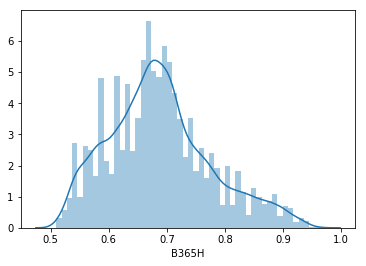

In [175]:
#Take an initial look at the dataframe
sns.distplot(df.B365H)



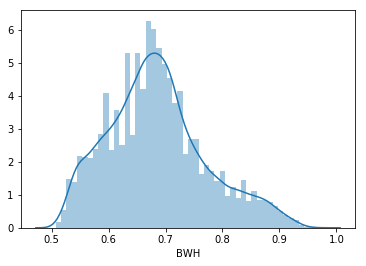

In [176]:
sns.distplot(df.BWH)

In [177]:
#sns.pairplot(df.loc[:,'B365H':'VCD'])

In [178]:
df.head(8)

,home_team_goal,away_team_goal,HomeWin,AwayWin,Draw,home_team_api_id,B365H,B365D,B365A,BWH,...,LBA,WHH,WHD,WHA,VCH,VCD,VCA,meanH,meanA,meanD
0,1,1,False,False,True,9987,0.633700,0.772727,0.833333,0.636364,...,0.789474,0.629630,0.767442,0.812383,0.622642,0.772727,0.818182,0.635719,0.806474,0.768726
1,0,0,False,False,True,10000,0.661017,0.761905,0.782609,0.642857,...,0.777778,0.646643,0.767442,0.782609,0.666667,0.764706,0.764706,0.654588,0.780576,0.764217
2,0,3,False,True,False,9984,0.704142,0.767442,0.733333,0.705882,...,0.714286,0.714286,0.764706,0.705882,0.701493,0.764706,0.726027,0.710385,0.715801,0.763716
3,5,0,True,False,False,9991,0.590164,0.789474,0.882353,0.583333,...,0.866667,0.590164,0.789474,0.857143,0.591837,0.789474,0.866667,0.588166,0.866961,0.791158
4,1,3,False,True,False,7947,0.833333,0.777778,0.622642,0.833333,...,0.632353,0.807692,0.772727,0.629630,0.818182,0.772727,0.622642,0.815423,0.625380,0.773530
5,1,1,False,False,True,8203,0.826087,0.772727,0.625468,0.829060,...,0.618321,0.807692,0.772727,0.629630,0.813084,0.772727,0.629630,0.816082,0.628091,0.769587
6,2,2,False,False,True,9999,0.677419,0.761905,0.767442,0.672131,...,0.782609,0.646643,0.767442,0.782609,0.677419,0.764706,0.750000,0.661563,0.769912,0.764684
7,1,2,False,True,False,4049,0.761905,0.772727,0.687500,0.718310,...,0.714286,0.729730,0.764706,0.692308,0.736842,0.764706,0.692308,0.727826,0.699694,0.765565


In [180]:
df.loc[:,'B365H':'VCD'].head(8)

,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD
0,0.633700,0.772727,0.833333,0.636364,0.770115,0.807692,0.649123,0.761905,0.777778,0.642857,0.767442,0.789474,0.629630,0.767442,0.812383,0.622642,0.772727
1,0.661017,0.761905,0.782609,0.642857,0.767442,0.797980,0.655172,0.761905,0.777778,0.655172,0.761905,0.777778,0.646643,0.767442,0.782609,0.666667,0.764706
2,0.704142,0.767442,0.733333,0.705882,0.767442,0.718310,0.722222,0.756098,0.696970,0.714286,0.761905,0.714286,0.714286,0.764706,0.705882,0.701493,0.764706
3,0.590164,0.789474,0.882353,0.583333,0.800000,0.871795,0.583333,0.795918,0.857143,0.590164,0.782609,0.866667,0.590164,0.789474,0.857143,0.591837,0.789474
4,0.833333,0.777778,0.622642,0.833333,0.777778,0.615385,0.800000,0.767442,0.629630,0.800000,0.772727,0.632353,0.807692,0.772727,0.629630,0.818182,0.772727
5,0.826087,0.772727,0.625468,0.829060,0.772727,0.622642,0.787234,0.761905,0.642857,0.833333,0.764706,0.618321,0.807692,0.772727,0.629630,0.813084,0.772727
6,0.677419,0.761905,0.767442,0.672131,0.764706,0.759036,0.649123,0.761905,0.777778,0.646643,0.767442,0.782609,0.646643,0.767442,0.782609,0.677419,0.764706
7,0.761905,0.772727,0.687500,0.718310,0.767442,0.705882,0.705882,0.761905,0.705882,0.714286,0.761905,0.714286,0.729730,0.764706,0.692308,0.736842,0.764706


In [181]:
#This is a single t-test for one comparison between bookies
x = df.B365H
y = df.BWH
ttest=stats.ttest_ind(x,y)
print('T-test independent, one tailed p-value: ', ttest[1]*2)



T-test independent, one tailed p-value:  0.002555342649707994


In [182]:
draw_df = df.loc[:,'B365D':'VCD':3].drop(df.index[0:df.shape[0]])
draw_df['Index_'] = df.loc[:,'B365D':'VCD':3].columns
draw_df.set_index('Index_')
None


In [183]:
away_win_df = df.loc[:,'B365A':'VCA':3].drop(df.index[0:df.shape[0]])
away_win_df['Index_'] = df.loc[:,'B365A':'VCA':3].columns
away_win_df.set_index('Index_')
None


In [184]:
home_win_df = df.loc[:,'B365H':'VCH':3].drop(df.index[0:df.shape[0]])
home_win_df['Index_'] = df.loc[:,'B365H':'VCH':3].columns
home_win_df.set_index('Index_')
None


In [185]:
home_win_df

,B365H,BWH,IWH,LBH,WHH,VCH,Index_
0,NaN,NaN,NaN,NaN,NaN,NaN,B365H
1,NaN,NaN,NaN,NaN,NaN,NaN,BWH
2,NaN,NaN,NaN,NaN,NaN,NaN,IWH
3,NaN,NaN,NaN,NaN,NaN,NaN,LBH
4,NaN,NaN,NaN,NaN,NaN,NaN,WHH
5,NaN,NaN,NaN,NaN,NaN,NaN,VCH


In [186]:
#This loops through the bookies to conduct individual one-to-one ttests for 
#bookies across similar odds
for bookie_1 in home_win_df:
    for index, bookie_2 in enumerate(home_win_df):
        if bookie_1 != "Index_" and bookie_2 != "Index_":
            x = df[bookie_1]
            y = df[bookie_2]
            ttest=stats.ttest_ind(x,y)
            home_win_df[bookie_1].iloc[index] = ttest[1]*2
home_win_df = home_win_df.set_index('Index_')

#Deletes repetive values to improve heatmap visualization
for i in range(home_win_df.shape[0]):
    for j in range(home_win_df.shape[1]):
        if j>=i:
            home_win_df.iloc[i,j] = None



Text(0.5, 51.0, '')

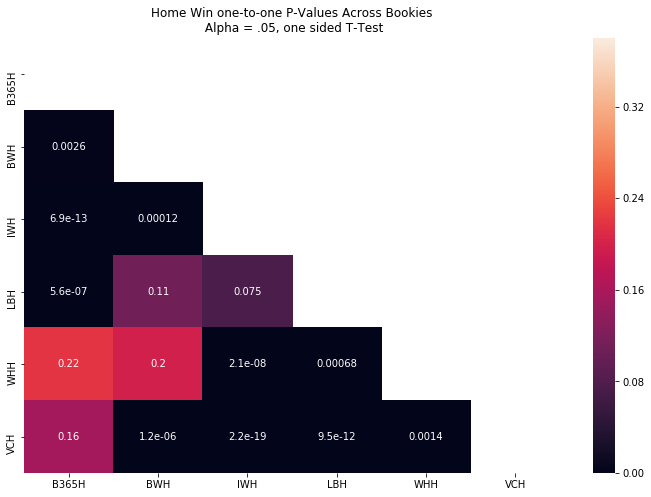

In [187]:
#This generates a heatmap
fig, ax = plt.subplots(figsize= (12,8))
sns.heatmap(home_win_df, vmin=0, vmax=.38, annot = True, ax = ax)
ax.set_title("Home Win one-to-one P-Values Across Bookies\n Alpha = .05, one sided T-Test")
ax.set_ylabel('')    
ax.set_xlabel('')


#The following bookie relationship show t-test p-values that attempt to reject the null
#hypothesis that they come from the same distribution at a 95% level of confidence, 
#most succeed, meaning the various bookie predictions are truly from different distributions.

#In the heatmap below the t-tests that successfully reject the null hypothesis are in dark blue.
#Lighter purple and magenta values denote failure to reject because the p-value is greater
#than .05  It should also be noted that these are individual comparisons between similar metrics 
#across individiual bookies, one to another.  There is one darker purple square with a p-value of .038 which
#does reject the null hypothesis.

#The following 5 t-tests comparisons failed to reject, meaning they come from the same underlying distribution
#at a 95% statistical confidence level for probability of a home team win:

#B365H to WHH
#B365H to VCH
#BWH to LBH
#BWH to WHH
#IWH to LBH


#key:

#B365H - Bet365
#BWH - Bet and Win
#IWH - Interwetten
#LBH - Ladbrokes
#WHH - William Hill 
#VCH - VC Bet

#"H" stands for home win



In [188]:
#This loops through the bookies to conduct individual one-to-one ttests for 
#bookies across similar odds
for bookie_1 in away_win_df:
    for index, bookie_2 in enumerate(away_win_df):
        if bookie_1 != "Index_" and bookie_2 != "Index_":
            x = df[bookie_1]
            y = df[bookie_2]
            ttest=stats.ttest_ind(x,y)
            away_win_df[bookie_1].iloc[index] = ttest[1]*2
away_win_df = away_win_df.set_index('Index_')

#Deletes repetive values to improve heatmap visualization
for i in range(away_win_df.shape[0]):
    for j in range(away_win_df.shape[1]):
        if j>=i:
            away_win_df.iloc[i,j] = None



Text(0.5, 51.0, '')

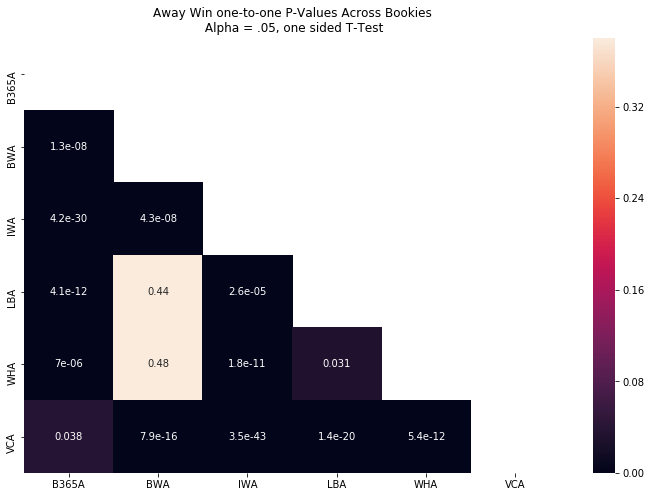

In [189]:
fig, ax = plt.subplots(figsize= (12,8))
sns.heatmap(away_win_df, vmin=0, vmax=.38, annot = True, ax = ax)
ax.set_title("Away Win one-to-one P-Values Across Bookies\n Alpha = .05, one sided T-Test")
ax.set_ylabel('')    
ax.set_xlabel('')

#The following bookie relationship show t-test p-values that attempt to reject the null
#hypothesis that they come from the same distribution at a 95% level of confidence, 
#most succeed, meaning the various bookie predictions are truly from different distributions.

#In the heatmap below the t-tests that successfully reject the null hypothesis are in dark blue.
#Purple values denote failure to reject because the p-value is greater
#than .05  It should also be noted that these are individual comparisons between similar metrics 
#across individiual bookies, one to another.  

#The following 2 ttest comparisons failed to reject, meaning they come from the same underlying distribution
#at a 95% statistical confidence level for probability of a home team win:

#RESULTS
#The distribtutions of Bet and Win away win, BWA and William Hill away win are not statistically different 
#at the .95 confidence level

#The distribtutions of Bet and Win away win, BWA, and Ladbrokes away win, LBA, are not statistically different 
#at the .95 confidence level

#key:

#B365A - Bet365
#BWA - Bet and Win
#IWA - Interwetten
#LBA - Ladbrokes
#WHA - William Hill 
#VCA - VC Bet

#"A" stands for away win



In [190]:
#This loops through the bookies to conduct individual one-to-one ttests for 
#bookies across similar odds
for bookie_1 in draw_df:
    for index, bookie_2 in enumerate(draw_df):
        if bookie_1 != "Index_" and bookie_2 != "Index_":
            x = df[bookie_1]
            y = df[bookie_2]
            ttest=stats.ttest_ind(x,y)
            draw_df[bookie_1].iloc[index] = ttest[1]*2
draw_df = draw_df.set_index('Index_')

#Deletes repetive values to improve heatmap visualization
for i in range(draw_df.shape[0]):
    for j in range(draw_df.shape[1]):
        if j>=i:
            draw_df.iloc[i,j] = None


Text(0.5, 51.0, '')

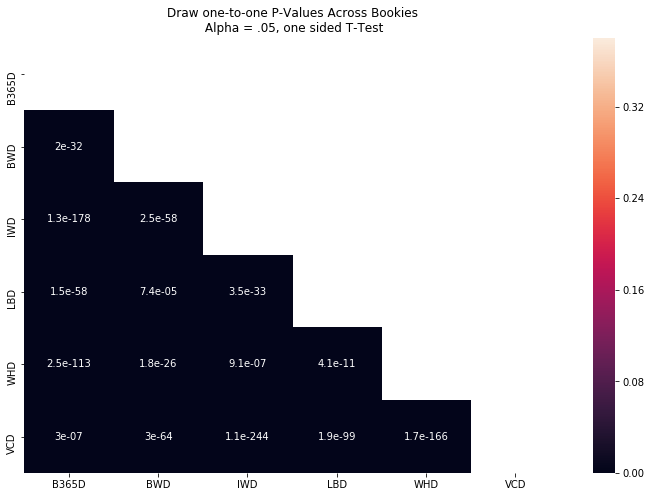

In [191]:
fig, ax = plt.subplots(figsize= (12,8))
sns.heatmap(draw_df, vmin=0, vmax=.38, annot = True, ax = ax)
ax.set_title("Draw one-to-one P-Values Across Bookies\n Alpha = .05, one sided T-Test")
ax.set_ylabel('')    
ax.set_xlabel('')

#The following bookie relationship show t-test p-values that attempt to reject the null
#hypothesis that they come from the same distribution at a 95% level of confidence, 
#and all succeed, meaning the various bookie predictions are truly from different distributions.

#In the heatmap below the t-tests that successfully reject the null hypothesis are in dark blue.
#Purple values denote failure to reject because the p-value is greater
#than .05  It should also be noted that these are individual comparisons between similar metrics 
#across individiual bookies, one to another.  

#key:

#B365D - Bet365
#BWD - Bet and Win
#IWD - Interwetten
#LBD - Ladbrokes
#WHD - William Hill 
#VCD - VC Bet

#"D" stands for away win


In [210]:
result = stats.f_oneway(df.B365H, df.BWH, df.IWH, df.LBH, df.WHH, df.VCH)
print(f'The p-value for this one way ANOVA test is {result[1]}')
print('Therefore, the null hypothesis that these populations come from the same underlying distrubtion')
print(f"was {('rejected' if result[1]<=.05 else 'not rejected')} at the .95 level of confindence.")



The p-value for this one way ANOVA test is 2.750142525557248e-22
Therefore, the null hypothesis that these populations come from the same underlying distrubtion
was rejected at the .95 level of confindence.


In [204]:
('rejected' if result[1]<=.05 else 'not rejected')

'rejected'

In [211]:
result = stats.f_oneway(df.B365A, df.BWA, df.IWA, df.LBA, df.WHA, df.VCA)
print(f'The p-value for this one way ANOVA test is {result[1]}')
print('Therefore, the null hypothesis that these populations come from the same underlying distrubtion')
print(f"was {('rejected' if result[1]<=.05 else 'not rejected')} at the .95 level of confindence.")

The p-value for this one way ANOVA test is 3.3042277037498044e-51
Therefore, the null hypothesis that these populations come from the same underlying distrubtion
was rejected at the .95 level of confindence.


In [212]:
stats.f_oneway(df.B365D, df.BWD, df.IWD, df.LBD, df.WHD, df.VCD)
print(f'The p-value for this one way ANOVA test is {result[1]}')
print('Therefore, the null hypothesis that these populations come from the same underlying distrubtion')
print(f"was {('rejected' if result[1]<=.05 else 'not rejected')} at the .95 level of confindence.")

The p-value for this one way ANOVA test is 3.3042277037498044e-51
Therefore, the null hypothesis that these populations come from the same underlying distrubtion
was rejected at the .95 level of confindence.


In [ ]:
#For all three of my one-way ANOVA tests, the null hypothesis that the individual distributions
#come from the same underlying distribution was rejected at the 95% level of confidence.

#This means essentially there is no single common distribution that can predict all the bookie's
#behavior for all three categories of odds, home wins, away wins, and draws.

In [ ]:
#The next thing I will test will be to see if each of the individual distributions differ
#from all the others when measure by a two-way ANOVA test


df=DataFrame()
df.read_tbl(datafile)
df['id'] = xrange(len(df['len']))

print(df.anova('len', sub='id', bfactors=['supp', 'dose']))

In [232]:
df[df.columns-'B365D']

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
#This loops through the bookies to conduct individual one-to-one ttests for 
#bookies across similar odds
for bookie in home_win_df:
        y = df[bookie]
        x = df[bookie_2]
        ttest=stats.ttest_ind(x,y)
        draw_df[bookie_1].iloc[index] = ttest[1]*2
draw_df = draw_df.set_index('Index_')

#Deletes repetive values to improve heatmap visualization
for i in range(draw_df.shape[0]):
    for j in range(draw_df.shape[1]):
        if j>=i:
            draw_df.iloc[i,j] = None

In [ ]:
formula = 'len ~ C(supp) + C(dose) + C(supp):C(dose)'
model = ols(formula, data).fit()
aov_table = anova_lm(model, typ=2)